In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
#crane_path = r'/work/cseos2g/datduyn/Documents/datasets/wine-quality/winequality-white.csv'
window_path = r'C:\Users\datng\Documents\datasets\wine-quality\winequality-white.csv'
#crane_path = r'/home/cse496dl/otiong/machineLearning/assignment_1/winequality-white.csv'
# window_path = r'C:\Users\onsai\CSCE478\datasets\DataScienceRepository\winequality-white.csv'

In [3]:
df = pd.read_csv(window_path,delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
# Make sure you run this line only once
df['quality'][df['quality'] <= 5] = 0 # Bad wine
df['quality'][df['quality'] > 5] = 1 # Good wine
df['quality'].value_counts()

c:\users\datng\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\datng\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1    3258
0    1640
Name: quality, dtype: int64

In [5]:
#Make sure to run this cell once
df = df.dropna()
df = df.drop(columns=['fixed acidity','residual sugar'], axis=1)

#### Choose the most correlated features

In [6]:
#run this cell only once
most_corr = df.corr()['quality'].sort_values(ascending=False)
df = df.ix[:, most_corr.index]
df.head()

c:\users\datng\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,quality,alcohol,pH,sulphates,citric acid,free sulfur dioxide,total sulfur dioxide,chlorides,volatile acidity,density
0,1,8.8,3.00,0.45,0.36,45.0,170.0,0.045,0.27,1.0010
1,1,9.5,3.30,0.49,0.34,14.0,132.0,0.049,0.30,0.9940
2,1,10.1,3.26,0.44,0.40,30.0,97.0,0.050,0.28,0.9951
3,1,9.9,3.19,0.40,0.32,47.0,186.0,0.058,0.23,0.9956
4,1,9.9,3.19,0.40,0.32,47.0,186.0,0.058,0.23,0.9956


### 20. Partition the data into train and test set
## Create dataset

In [7]:
y = df['quality']
X = df.drop('quality', axis=1)

print("X shape:", X.shape)
print("y shape:",y.shape)

X shape: (4898, 9)
y shape: (4898,)


In [8]:
def split_train_test(X, y, 
                     partition_percent=[.8,.2], shuffle=False):
    '''
    Partioning the data:
    args:
        - X: train set numpy or dataframe with shape(N,D)
        - y: labels numpy or dataframe with shape(N,)
        - partition_percent: python list of data percentage
         to partition. ex: [.8, .2] -> part of data
         will be split to .8 and part will be .2.
         NOTE: have to sum up to 1.0
        - shuffle: shuffle before partitioning or not?
    '''
    
    #convert from panda series to numpy
    try:
        X = X.as_matrix()
        y = y.as_matrix()
    except: #incase given X, y is already a numpy arra
        pass
    
    N = X.shape[0]
    if(sum(partition_percent) != 1.0):
        raise ValueError("Partition_percent should add up to 1.0")
    if shuffle:
        X = np.random.shuffle(X)
    
    split_sets = []
    s = [] #[X1,y1, X2, y2, X3, y3...]
    prev_idx = 0
    for idx,part in enumerate(partition_percent):
        range_idx = int(N * part)
        if(idx == len(partition_percent)-1):
            split_sets.append(X[prev_idx:])
            split_sets.append(y[prev_idx:])
        else:
            split_sets.append(X[prev_idx:prev_idx+range_idx])
            split_sets.append(y[prev_idx:prev_idx+range_idx])
        prev_idx = prev_idx+range_idx
        
    return split_sets


print('X', len(X))
X_train, y_train, X_test, y_test= split_train_test(X, y, 
                partition_percent=[.8,.2], 
                shuffle=False)

#create dev set for debuging
X_dev = X_train[0:10].copy()
y_dev = y_train[0:10].copy()

# Check shape
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

print("X_dev",X_dev.shape)
print("y_dev",y_dev.shape)

X 4898
X_train (3918, 9)
y_train (3918,)
X_test (980, 9)
y_test (980,)
X_dev (10, 9)
y_dev (10,)


c:\users\datng\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\datng\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
import math
def polynomialFeatures(X, degree):
    '''
    Arguments:

    X : ndarray 
        A numpy array with rows representing data samples and columns representing features (d-dimensional feature).

    degree : integer
        The degree of the polynomial features. Default = 1.

    Returns:

        A new feature matrix consisting of all polynomial combinations of the features with degree equal to the specified degree. 
        For example, if an input sample is two dimensional and of the form [a, b], 
        the degree-2 polynomial features are [a, b, a2, ab, b2].
    '''
    map_term = {}
    poly_term = []
    result_term = []
    for i in range(X.shape[1]):
        map_terms[i] = X[:,i]
        poly_term.append(i)

    terms = get_polynomial(poly_term, degree)
    result = 1
    for sublst in terms:
        for x in sublst:
            if x == 'cons':
                result *= np.ones((X.shape[0],), dtype=int)
            else:
                result *= map_terms[x] 
                
        result_term.append(result)
        result = 1
    
    return np.array(result_term).T

def get_polynomial(vars, degree):

    vars.append("cons") # add dummy variable
    
    # compute all combinations of variables
    terms = []
    for x in itertools.combinations_with_replacement(vars, degree):
        terms.append(x)

    # get rid of "c" terms
    terms = map(list, terms)
    terms = list(terms)
 
    return terms

def mse(Y_true, Y_pred):
    '''
    Arguments: 
        Y_true : ndarray 1D array containing data with “float” type. True y values.
        Y_pred : ndarray 1D array containing data with “float” type. Values predicted by your model.

    Returns:
        cost: float It returns a float value containing mean squared error between Y_true and Y_pred.

    Note: these 1D arrays should be designed as column vectors.
    '''
    return sum((Y_true-Y_pred)**2)

def learning_curve(model, X, Y, cv, train_size=1, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    '''
    Arguments: 
        model: object type that implements the “fit” and “predict” methods. An object of that type which is cloned for each validation.
        
        X: ndarray A numpy array with rows representing data samples and columns representing features.
        
        Y: ndarray A 1D numpy array with labels corresponding to each row of the feature matrix X.
        
        cv : int integer, to specify the number of folds in a k-fold cross-validation.
        
        train_sizes : intor float Relative or absolute numbers of training examples that will be used to generate the learning curve. 
            If the dtype is float, it is regarded as a fraction of the maximum size of the training set 
            (that is determined by the selected validation method), i.e. it has to be within (0, 1]. 
            Otherwise it is interpreted as absolute sizes of the training sets. 
        
        learning_rate: float It provides the step size for parameter update.
        
        epochs :int The maximum number of passes over the training data for updating the weight vector.
        
        tol : float or None The stopping criterion. If it is not None, the iterations will stop when (error> previous_error-tol). 
            If it is None, the number of iterations will be set by the “epochs”.
        
        regularizer: string The string value could be one of the following: l1, l2, None. 
            If it’s set to None, the cost function without the regularization term will be used for computing the gradient 
            and updating the weight vector. However, if it’s set to l1 or l2, the appropriate regularized cost function needs to be used 
            for computing the gradient and updating the weight vector.
        
        lambd: floatIt provides the regularization coefficient. It is used only when the “regularizer” is set to l1 or l2.
        
    Returns:
        train_scores : ndarray root-mean-square error(rmse) values on training sets.
        
        val_scores : ndarray root-mean-square error(rmse) values on validation sets.    
    '''
#edge case: value of cv must be more than sample size/ cannot be 1
    num_iteration = math.ceil(X.shape[0]/train_size)
    train_scores = []
    val_scores = []
    for i in range(1, num_iteration + 1):
        cur_X = X[0:(i*train_size)]
        cur_Y = Y[0:(i*train_size)]
        x_train_folds = np.array(np.array_split(cur_X, cv))
        y_train_folds = np.array(np.array_split(cur_Y, cv))
        
        train_score = 0
        val_score = 0
        for idx, val_fold in enumerate(x_train_folds):
            train_folds = [f for i, f in enumerate(x_train_folds) if(i != idx)][0] #[0]: unpacking the outer list
            label_folds = [f for i, f in enumerate(y_train_folds) if(i != idx)][0]

            # Train the model
            model.fit(train_folds, label_folds)

            train_pred = model.predict(train_folds)
            val_pred = model.predict(val_fold)

            train_score += (mse(label_folds, train_pred))
            val_score += (mse(y_train_folds[idx], val_pred))
            
        train_scores.append(train_score/cv)
        val_scores.append(val_score/cv)
    
    return np.sqrt(train_scores), np.sqrt(val_scores)
    

a, b =learning_curve(LinearRegression(), X_train, y_train, 5, train_size=50, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0)
print(a, b)

[1.90234465e-13 1.05647588e+00 1.49743452e+00 2.39125446e+00
 2.88910586e+00 3.02551287e+00 3.33277635e+00 3.64294426e+00
 3.88016965e+00 4.06421475e+00 4.37772143e+00 4.62125335e+00
 4.79915716e+00 4.98573493e+00 5.12999348e+00 5.32476289e+00
 5.56245127e+00 5.73226622e+00 5.88773679e+00 6.05570512e+00
 6.24229196e+00 6.38323263e+00 6.55937844e+00 6.77073589e+00
 6.82631682e+00 6.98051166e+00 7.14916350e+00 7.28422402e+00
 7.39666471e+00 7.48327885e+00 7.60771521e+00 7.72024066e+00
 7.91425200e+00 8.02866213e+00 8.17211004e+00 8.25260090e+00
 8.33673099e+00 8.37120060e+00 8.46108162e+00 8.60060579e+00
 8.72189325e+00 8.88141863e+00 8.94571249e+00 9.04048900e+00
 9.14763654e+00 9.25079473e+00 9.36100427e+00 9.46187021e+00
 9.54652782e+00 9.64531177e+00 9.73687514e+00 9.80596825e+00
 9.93746092e+00 1.00691090e+01 1.01287879e+01 1.02069614e+01
 1.03063650e+01 1.03751300e+01 1.04646581e+01 1.05382883e+01
 1.06134996e+01 1.06738064e+01 1.07443450e+01 1.08339053e+01
 1.09287814e+01 1.103785

In [4]:
def sgd(w, dw, learning_rate=1e-2):
    w -= learning_rate * dw
    return w


class LinearRegression(object):
    def __init__(self, optim=sgd):
        self.optim = sgd
        self.params = {} #save model weights

    def predict(self, X):
        return X.dot(self.params['w']).reshape(-1) + self.params['b'] #(N,D) dot (D,1) = (N,1)
    
    def loss(self, X, y):
        N, D = self.X.shape
        grads = {}#return gradient for Gradient descent update
        #forward pass
        scores = self.predict(X)

        #backward pass
        loss, grads = 0.0, {}
        
        loss = (0.5/N) * np.sum((y-scores)**2)
        #get mse loss and dout here
        dout = (1/N) * (scores - y) 
        
        #y = wx + b -> dy/db = dout/dy * dy/db = dout * 1.0
        grads['b'] = np.sum(dout)
        
        #dout/dw = dout/dy dot dy/dw = dout dot x
        #shape: (N,1) dot (N,D) -> X.T.dot(dout)
        grads['w'] = dout.T.dot(X).reshape(-1, 1)

        return loss, grads
    
    def fit(self, X, Y, learning_rate=1e-1, 
                   epochs=300, tol=1e-4, regularizer=0.0,
                   lambd=None, verbose=False):
        '''
        Inputs:
        - X: numpy array of inputs vector  (N, D)
        - Y: numpy array of target vector (N,)
        - learning_rate: float provide the step size
        - epochs: int provide number of passes through in dataset
        - tol: float or None provide the stopping criterion
        - regularizer: string of 'l1' or 'l2'
        - lambd: float provide regularize coeff
        '''
        loss_hist = []
        self.X = X
        self.y = Y
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        self.tol = tol
        
        self.epochs = epochs
        
        N, D = self.X.shape
        
        self.params['w'] = np.random.randn(D,1)
        self.params['b'] = 0.0
        
        for e in range(self.epochs):
            loss, grads = self.loss(self.X, self.y)
            
            #perform gradient descent params update
            for p, w in self.params.items():
                dw = grads[p]
                config={'learning_rate':self.learning_rate}
                next_w = self.optim(w, dw, self.learning_rate)
                self.params[p] = next_w
                
            if verbose: print('epoch', e, 'loss', loss)
            loss_hist.append(loss)
        return loss_hist

In [5]:
LR = LinearRegression()

X = np.array([
    [2,3,4],
    [1,2,2]
])
y = np.array([0,3])
# LR.predict(X)

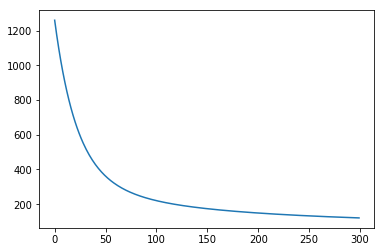

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
#sanity
LR = LinearRegression()
X = np.random.randn(10,10)
y = np.random.randint(100, size=(10,))
loss_hist = LR.fit(X, y, learning_rate=1e-2, verbose=False)
plt.plot(loss_hist)

# print('________expected_________')
# LR_sk = sklearn.linear_model.LinearRegression()
# LR.fit(X, y, learning_rate=1e-2, verbose=False)
# LR_sk = sklearn.linear_model.LinearRegression()
# LR_sk.fit(X, y)

## Numerical gradient check

Using Calculus method
$$
f(h) = \frac{f(x+h) - f(x-h)}{2 h}
$$

- for more info refer to; http://deeplearning.stanford.edu/tutorial/supervised/DebuggingGradientChecking/

In [8]:
def eval_numerical_grad(f, x, h=.0001):
    fx = f(x) #eval
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        mask = np.zeros_like(x)
        mask[ix] = 1
        Lp = ((f(x) + h) * mask).sum()
        Lm = ((f(x) - h) * mask).sum()
        grad[ix] = (Lp - Lm) /(2 * h)
        print(grad[ix])
    return grad